# 04-Deep Learning

In [1]:
import torch

In [11]:
!pip install matplotlib

  Using cached matplotlib-3.9.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.2-cp311-cp311-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp311-cp311-macosx_11_0_arm64.whl (250 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.54.1-cp311-cp311-macosx_11_0_arm64.whl (2.3 MB)
Using cached kiwisolver-1.4.7-cp311-cp311-macosx_11_0_arm64.whl (64 kB)
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)


In [12]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [13]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [14]:
len(dataset)

60000

image shape:  torch.Size([1, 28, 28])
Label:  5


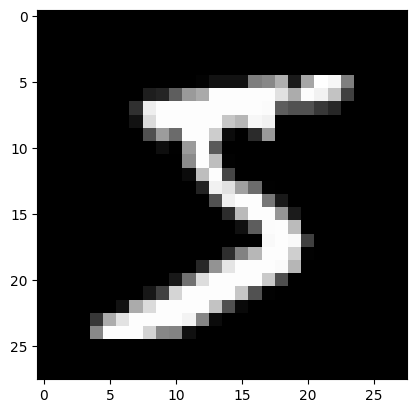

In [15]:
image, label = dataset[0]
print('image shape: ', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label: ', label)

In [16]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [17]:
batch_size = 128

In [18]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape:  torch.Size([128, 1, 28, 28])


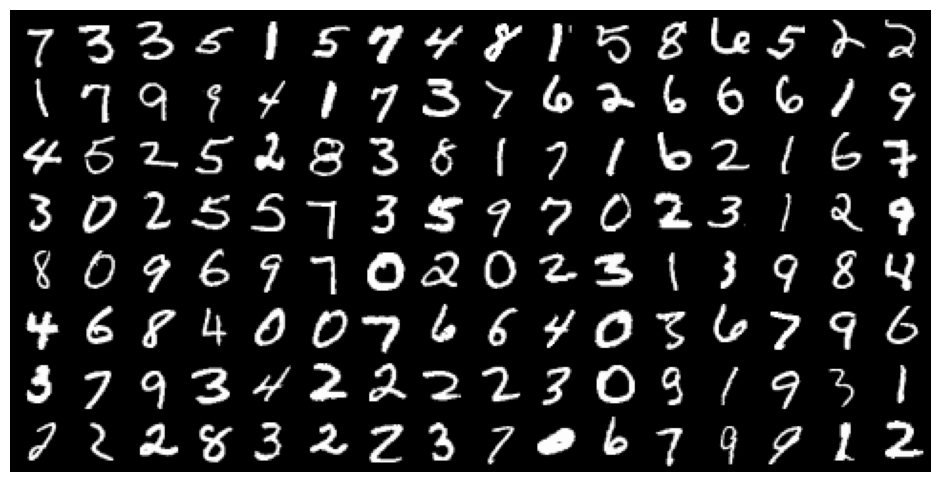

In [19]:
for images, _ in train_loader:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16,6))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [20]:
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape: ', inputs.shape)
    break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shape:  torch.Size([128, 784])


In [21]:
input_size = inputs.shape[-1]
hidden_size = 32

In [22]:
layer1 = nn.Linear(input_size, hidden_size)

In [23]:
inputs.shape

torch.Size([128, 784])

In [24]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape: ', layer1_outputs.shape)

layer1_outputs.shape:  torch.Size([128, 32])


In [25]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [26]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [27]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_ouputs): ', torch.min(layer1_outputs).item())
print('min(relu_outputs): ', torch.min(relu_outputs).item())

min(layer1_ouputs):  -0.6636382937431335
min(relu_outputs):  0.0


In [28]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)
layer2_outputs = layer2(relu_outputs)
layer2_outputs.shape

torch.Size([128, 10])

## Model

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [59]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [60]:
input_size = 784
hidden_size = 32
num_classes = 10


In [61]:
model = MnistModel(input_size, hidden_size, out_size=num_classes)

In [62]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for image, label in train_loader:
    outputs = model(images)
    break

loss = F.cross_entropy(outputs, label)
print('Loss: ', loss.item())
print('Output.shape: ', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

In [65]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device('cpu')

In [66]:
get_default_device()

device(type='mps')

In [37]:
device = get_default_device()
device

device(type='cpu')

In [67]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [49]:
# device = torch.device('mps')

In [69]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [70]:
for xb, yb in val_loader:
    print("xb.device: ", xb.device)
    print('yb: ', yb)
    break

xb.device:  mps:0
yb:  tensor([0, 5, 1, 9, 7, 2, 2, 9, 3, 1, 6, 0, 2, 7, 4, 6, 0, 6, 5, 2, 1, 9, 4, 1,
        7, 6, 8, 2, 9, 0, 4, 0, 9, 4, 4, 7, 9, 6, 4, 3, 4, 0, 2, 7, 1, 1, 4, 4,
        5, 0, 1, 8, 6, 3, 5, 7, 2, 2, 6, 3, 4, 1, 1, 7, 7, 5, 3, 7, 5, 8, 7, 1,
        8, 7, 0, 2, 0, 3, 6, 3, 7, 3, 8, 7, 6, 3, 9, 9, 4, 0, 5, 0, 1, 3, 6, 3,
        1, 1, 5, 7, 1, 2, 0, 5, 6, 1, 5, 9, 3, 1, 1, 9, 4, 4, 7, 1, 0, 6, 6, 7,
        9, 7, 6, 1, 4, 3, 3, 6, 9, 6, 9, 7, 6, 2, 7, 6, 6, 3, 7, 0, 9, 8, 5, 6,
        2, 4, 3, 2, 7, 4, 4, 1, 2, 7, 4, 8, 2, 1, 3, 2, 0, 5, 1, 1, 2, 4, 6, 9,
        4, 6, 1, 8, 4, 3, 4, 6, 8, 2, 7, 9, 4, 3, 3, 6, 1, 0, 3, 7, 1, 8, 0, 9,
        5, 8, 5, 0, 3, 4, 2, 5, 1, 5, 6, 6, 1, 1, 7, 1, 9, 9, 7, 0, 5, 4, 1, 5,
        3, 6, 6, 8, 6, 1, 1, 1, 3, 9, 2, 6, 2, 5, 1, 8, 7, 3, 6, 5, 7, 1, 2, 3,
        4, 9, 4, 1, 2, 3, 4, 2, 0, 0, 9, 0, 4, 8, 1, 5], device='mps:0')


In [72]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [73]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, torch.device('mps'))

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [74]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3090837001800537, 'val_acc': 0.08271484076976776}]

In [75]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2321, val_acc: 0.9309
Epoch [1], val_loss: 0.1830, val_acc: 0.9454
Epoch [2], val_loss: 0.1640, val_acc: 0.9528
Epoch [3], val_loss: 0.1570, val_acc: 0.9541
Epoch [4], val_loss: 0.1549, val_acc: 0.9534


In [76]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1260, val_acc: 0.9629
Epoch [1], val_loss: 0.1250, val_acc: 0.9629
Epoch [2], val_loss: 0.1256, val_acc: 0.9633
Epoch [3], val_loss: 0.1231, val_acc: 0.9632
Epoch [4], val_loss: 0.1217, val_acc: 0.9648


Text(0.5, 1.0, 'Loss vs Epochs')

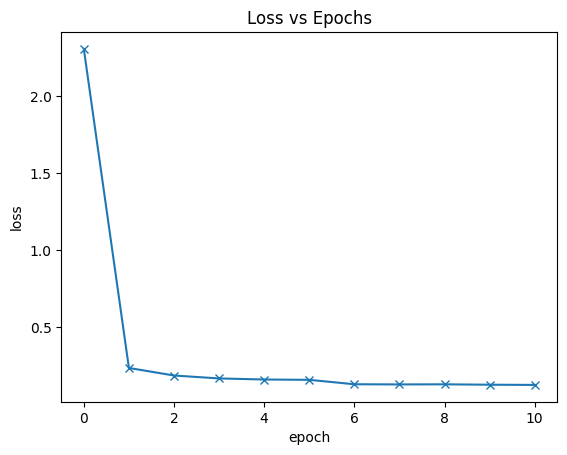

In [78]:
# Plotting Losses
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epochs')

Text(0.5, 1.0, 'Accuracy vs Epochs')

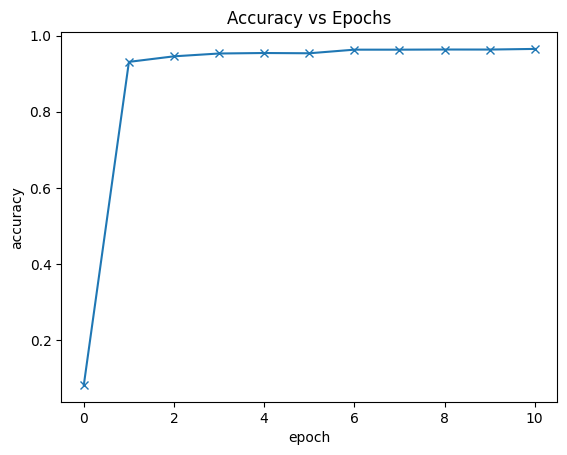

In [ ]:
# Plotting Accuracies
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs Epochs')

In [81]:
test_dataset = MNIST(
    root="data/",
    train=False,
    transform=ToTensor()
)

In [87]:
device

device(type='mps')

In [88]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    print(xb.device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

mps:0
Label:  7  , Predicted:  7


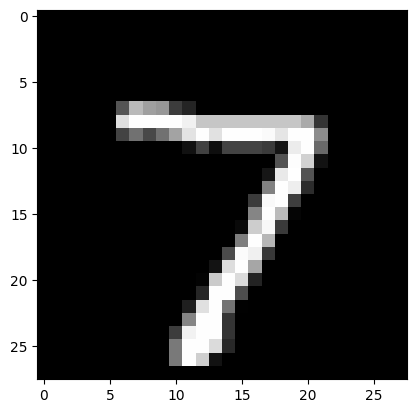

In [89]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ' , Predicted: ', predict_image(img, model))

Label:  9  , Predicted:  9


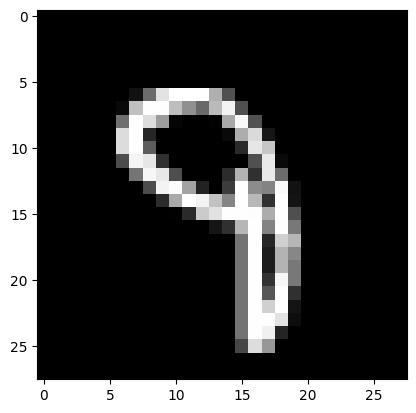

In [85]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ' , Predicted: ', predict_image(img, model))

Label:  2  , Predicted:  2


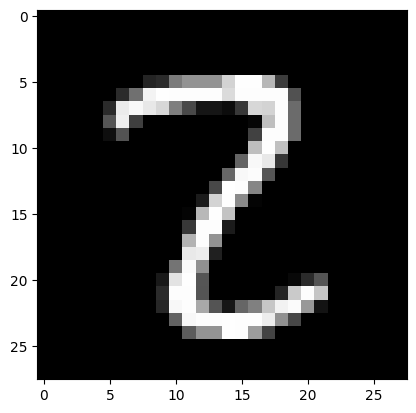

In [83]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ' , Predicted: ', predict_image(img, model))

In [90]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10673774778842926, 'val_acc': 0.9696289300918579}

In [91]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')